<img src="https://www.escoladnc.com.br/wp-content/uploads/2022/06/dnc_formacao_dados_logo_principal_preto-1.svg" alt="drawing" width="300"/>

# Métricas de Acurária e Cobertura

Neste notebook iremos avaliar a qualidade da recomendação dos seguintes modelos estudados neste curso:

- **Top** (Módulo 02 - Recomendação Não-personalizada)
- **ItemKNN** (Módulo 04 - Collaborative Filtering)
- **FunkSVD** (Módulo 04 - Collaborative Filtering)

Para realizar as avaliações, será utilizada a biblioteca [Rexmex](https://rexmex.readthedocs.io/en/latest/index.html) que contém a implementação de diversas métricas.

**Nota**: Para instalar a biblioteca `rexmex` descomente a linha abaixo e execute a célula.

In [35]:
# !pip install rexmex --upgrade

In [3]:
import os
import pandas as pd
from google.colab import files
import matplotlib.pyplot as plt
import matplotlib
from cycler import cycler

matplotlib.rcParams['axes.prop_cycle'] = cycler(color=['#007efd', '#FFC000', '#303030'])
pd.options.mode.chained_assignment = None 

# Carregamento dos datasets

Para focarmos somente na análise dos resultados, utilizaremos um **dataset pré-processado contendo a as métricas de validação** dos modelos citados anteriormente.

Além disso, vale lembrar que todos os modelos foram treinados utilizando o dataset do `MovieLens`. O conjunto de validação é formado por 20% dos dados mais recentes do dataset.

## Arquivo de metadados dos itens

Upload file `movies.parquet`

In [5]:
%%time
_ = files.upload() # approx: 10s

Saving movies.parquet to movies.parquet
CPU times: user 220 ms, sys: 27.5 ms, total: 248 ms
Wall time: 20 s


In [6]:
df_items = pd.read_parquet('movies.parquet')
df_items.set_index('item_id', inplace=True)
df_items.tail()

,title,genres
item_id,,
3948,Meet the Parents (2000),Comedy
3949,Requiem for a Dream (2000),Drama
3950,Tigerland (2000),Drama
3951,Two Family House (2000),Drama
3952,"Contender, The (2000)",Drama|Thriller


## Arquivo de métricas do conjunto de validação

Upload file `valid_metrics.parquet`

In [7]:
%%time
_ = files.upload() # approx: 25s

Saving valid_metrics.parquet to valid_metrics.parquet
CPU times: user 360 ms, sys: 46 ms, total: 406 ms
Wall time: 30.9 s


In [8]:
filepath = './valid_metrics.parquet'
df = pd.read_parquet(filepath)
print ('Modelos: ', df['model'].unique())
df.tail(5)

Modelos:  ['itemknn' 'top' 'svd']


,user_id,y_true,model,y_score
1778,6001,"[{'item_id': 3751, 'rating': 4}, {'item_id': 3...",svd,"[{'item_id': 858.0, 'score': 5.0}, {'item_id':..."
1779,6002,"[{'item_id': 1942, 'rating': 5}, {'item_id': 4...",svd,"[{'item_id': 913.0, 'score': 4.907493002485642..."
1780,6016,"[{'item_id': 3756, 'rating': 3}, {'item_id': 3...",svd,"[{'item_id': 1212.0, 'score': 4.31254496119922..."
1781,6028,"[{'item_id': 3000, 'rating': 4}]",svd,"[{'item_id': 2905.0, 'score': 4.44793890554711..."
1782,6040,"[{'item_id': 3182, 'rating': 5}, {'item_id': 2...",svd,"[{'item_id': 1212.0, 'score': 4.69464081583757..."


# Definição de Ranking

Para analisar a relação entre o tamanho da lista recomendada e as métricas de avaliação, consideraremos o ranking dos itens para cada usuário.

In [14]:
RANKS = list(range(1, 21))
RANKS

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]

# Análise de Métricas

A função `plot_report` abaixo será utilizada para auxiliar na análise das métricas

In [37]:
def plot_report(report, figsize=(16,10)):
  metrics = report.drop(['model', 'rank'], axis=1).columns
  fig, axes = plt.subplots(nrows=len(metrics), ncols=1, sharex=True, figsize=figsize)
  axes = [axes] if len(metrics) == 1 else axes
  for i, metric in enumerate(metrics):
    ax = axes[i]
    for model in report['model'].unique():
      df_plot = report.query('model == @model').sort_values(by='rank')
      ax.plot(df_plot['rank'], df_plot[metric], label=model)
      ax.scatter(df_plot['rank'], df_plot[metric])

    ax.set_xticks([int(rank) for rank in df_plot['rank']])
    ax.set_title(metric.title())
    ax.legend()
    ax.grid(True, linestyle='--')

  ax.set_xlabel('Rank')
  return fig, axes

# Cobertura de Itens

Para analisar a cobertura de itens da recomendação, precisamos:

- Considerar o tamanho da lista recomendada ($rank$)

In [42]:
def convert_coverage_metrics(df, rank=20):
  """recommended items"""
  df_true = df
  df_true = df_true.explode('y_true')[['model', 'user_id', 'y_true']]
  df_true['item_id'] = df_true['y_true'].apply(lambda x: x.get('item_id'))
  df_true['y_true'] = df_true['y_true'].apply(lambda x: x.get('rating'))

  df_score = df
  df_score = df_score.explode('y_score')[['model', 'user_id', 'y_score']]
  df_score['item_id'] = df_score['y_score'].apply(lambda x: x.get('item_id'))
  df_score['y_score'] = df_score['y_score'].apply(lambda x: x.get('score'))
  df_score['y_score'] = df_true['y_true'].max() * df_score['y_score'] / df_score['y_score'].max()
  
  df_metrics = df_true.merge(df_score, on=['model', 'user_id', 'item_id'], how='outer')
  df_metrics.sort_values(by=['user_id', 'y_score'], ascending=False, inplace=True)
  df_metrics['rank'] = df_metrics.groupby(['model', 'user_id'])['y_score'].rank(method='first', ascending=False)
  df_metrics = df_metrics.query('rank <= @rank')
  df_metrics['y_true'] = df_metrics['y_true'].fillna(0)

  return df_metrics[['model', 'user_id', 'item_id', 'y_true', 'y_score']].reset_index(drop=True)

df_metrics = convert_coverage_metrics(df.query('model == "top"'), rank=5)
df_metrics.tail()

,model,user_id,item_id,y_true,y_score
8910,top,1,2858.0,0.0,5.000000
8911,top,1,260.0,4.0,4.362602
8912,top,1,1196.0,0.0,4.361144
8913,top,1,1210.0,0.0,4.205076
8914,top,1,480.0,0.0,3.897316


In [54]:
from rexmex.metrics.coverage import item_coverage

model = 'svd'
rank = 20
df_metrics = convert_coverage_metrics(df.query('model == @model'), rank=rank)

item_ids    = df_items.index.unique().tolist()
user_ids    = df_metrics['user_id'].unique().tolist()
user_items  = df_metrics[['user_id', 'item_id']].values.tolist()

coverage = item_coverage((user_ids, item_ids), user_items)
print (f'Coverage: {coverage}')

Coverage: 0.143


In [47]:
def get_coverage_report(df, ranks, item_ids):
  coverage_report = pd.DataFrame(columns=['model', 'rank', 'item_coverage'])
  for rank in ranks:
    for i, model in enumerate(df['model'].unique()):
      df_metrics = convert_coverage_metrics(
          df.query('model == @model'),
          rank=rank
      )
      user_ids = df_metrics['user_id'].unique().tolist()
      user_items = df_metrics[['user_id', 'item_id']].values.tolist()
      coverage = item_coverage((user_ids, item_ids), user_items)

      coverage_report.loc[coverage_report.shape[0]] = [model, rank, coverage]

  return coverage_report.sort_values(by=['model', 'rank']).reset_index(drop=True)

item_ids = df_items.index.unique().tolist()
coverage_report = get_coverage_report(df, RANKS, item_ids)
coverage_report.tail(5)

,model,rank,item_coverage
55,top,16,0.004
56,top,17,0.004
57,top,18,0.005
58,top,19,0.005
59,top,20,0.005


(<Figure size 1152x576 with 1 Axes>,
 [<matplotlib.axes._subplots.AxesSubplot at 0x7f331db5c550>])

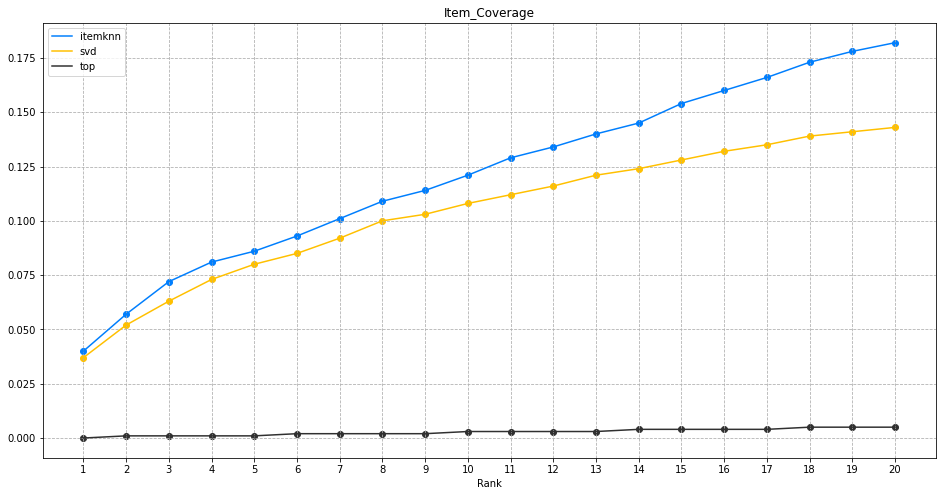

In [48]:
plot_report(coverage_report, figsize=(16,8))

______________________

# Métricas de Acurácia

## Personalização e Acurácia de Ranqueamento

Para analisarmos a recomendação como um problema de ranqueamento precisamos:

- Transformar a recomendação em listas ordenadas pelo _score_
- Considerar o tamanho da lista recomendada ($rank$)

In [55]:
def convert_ranking_metrics(df, rank=20):
  """
    y_true: recommended items that were consumed
    y_score: recommended items within rank
  """
  df_true = df
  df_true = df_true.explode('y_true')[['model', 'user_id', 'y_true']]
  df_true['item_id'] = df_true['y_true'].apply(lambda x: x.get('item_id'))
  df_true['y_true'] = df_true['y_true'].apply(lambda x: x.get('rating'))
  df_true = df_true.query('y_true > 0')
  df_true = df_true.groupby(['model', 'user_id']).agg({'item_id': list}).reset_index()
  df_true.rename({'item_id': 'y_true'}, axis=1, inplace=True)

  df_score = df
  df_score = df_score.explode('y_score')[['model', 'user_id', 'y_score']]
  df_score['item_id'] = df_score['y_score'].apply(lambda x: x.get('item_id'))
  df_score['y_score'] = df_score['y_score'].apply(lambda x: x.get('score'))
  df_score['rank'] = df_score.groupby(['model', 'user_id'])['y_score'].rank(method='first', ascending=False)
  df_score = df_score.query('rank <= @rank')
  df_score = df_score.groupby(['model', 'user_id']).agg({'item_id': list}).reset_index()
  df_score.rename({'item_id': 'y_score'}, axis=1, inplace=True)
  
  df_metrics = df_score.merge(df_true, on=['model', 'user_id'], how='left')
  df_metrics['y_true'] = df_metrics.apply(lambda x: list(set(x['y_true']).intersection(x['y_score'])), axis=1)
  
  return df_metrics[['model', 'user_id', 'y_true', 'y_score']].reset_index(drop=True)
  

df_metrics = convert_ranking_metrics(df.query('model == "itemknn"'), rank=10)
df_metrics

,model,user_id,y_true,y_score
0,itemknn,1,[1.0],"[1.0, 2677.0, 2649.0, 2650.0, 2651.0, 2652.0, ..."
1,itemknn,2,[],"[1.0, 2677.0, 2649.0, 2650.0, 2651.0, 2652.0, ..."
2,itemknn,3,[],"[1.0, 2677.0, 2649.0, 2650.0, 2651.0, 2652.0, ..."
3,itemknn,4,[],"[1.0, 2677.0, 2649.0, 2650.0, 2651.0, 2652.0, ..."
4,itemknn,5,[],"[1.0, 2677.0, 2649.0, 2650.0, 2651.0, 2652.0, ..."
...,...,...,...,...
1778,itemknn,6001,[],"[3172.0, 1471.0, 3656.0, 3232.0, 3881.0, 989.0..."
1779,itemknn,6002,[],"[3656.0, 3522.0, 3233.0, 989.0, 3382.0, 3881.0..."
1780,itemknn,6016,[],"[3656.0, 3522.0, 787.0, 1471.0, 1830.0, 989.0,..."
1781,itemknn,6028,[],"[3233.0, 3382.0, 3522.0, 1830.0, 2309.0, 1471...."


In [56]:
from rexmex.metrics.ranking import mean_reciprocal_rank, personalization

def get_ranking_report(df, ranks):
  ranking_report = pd.DataFrame(columns=['model', 'rank', 'mrr', 'personalization'])
  for rank in ranks:
    for i, model in enumerate(df['model'].unique()):
      df_metrics = convert_ranking_metrics(
          df.query('model == @model'),
          rank=rank
      )

      mrr = df_metrics.apply(
          lambda x: mean_reciprocal_rank(x["y_true"], x["y_score"]) if len(x['y_true']) > 0 and len(x['y_score']) else 0,
          axis=1
      ).mean()
      pers = personalization(df_metrics['y_score'])
      ranking_report.loc[ranking_report.shape[0]] = [model, rank, mrr, pers]

  return ranking_report.sort_values(by=['model', 'rank']).reset_index(drop=True)

ranking_report = get_ranking_report(df, RANKS)
ranking_report.tail()

,model,rank,mrr,personalization
55,top,16,0.175487,0.000000e+00
56,top,17,0.171112,0.000000e+00
57,top,18,0.166104,-2.220446e-16
58,top,19,0.162375,1.110223e-16
59,top,20,0.158608,-2.220446e-16


(<Figure size 1152x576 with 2 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f331db5cfa0>,
       dtype=object))

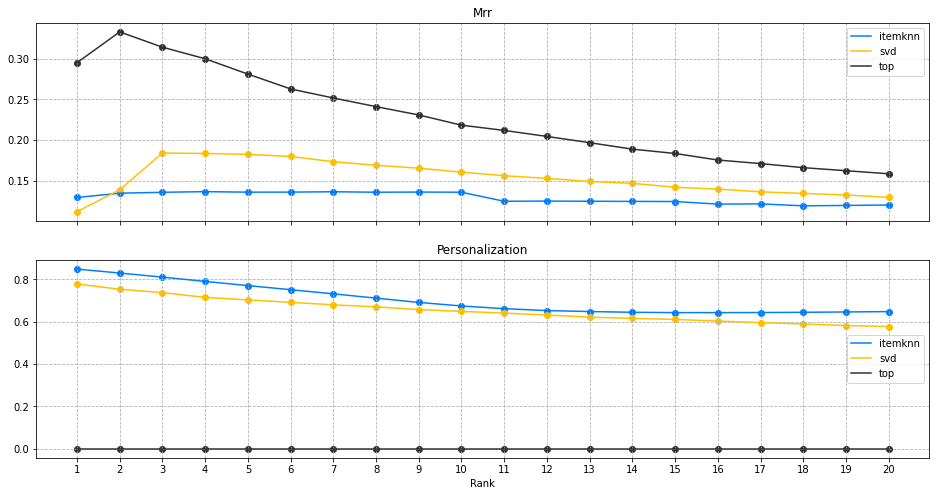

In [57]:
plot_report(ranking_report, figsize=(16,8))

## Acurácia de Classificação

Para analisar a recomendação como um problema de classificação precisamos:

- Classificar os itens como `consumido` ($rating \geq 1$) e `não-consumido` ($rating = 0$)
- Normalizar o _score_ dos algoritmos no intervalo $[0, 1]$

**Nota**: a biblioteca `rexmex` exige que o feedback do usuário e o score do algoritmo tenham os nomes *y_true* e *y_score*, respectivamente.

In [58]:
def convert_classification_metrics(df, threshold=1, rank=20):
  """known or recommended items"""
  df_score = df
  df_score = df_score.explode('y_score')[['model', 'user_id', 'y_score']]
  df_score['item_id'] = df_score['y_score'].apply(lambda x: x.get('item_id'))
  df_score['y_score'] = df_score['y_score'].apply(lambda x: x.get('score'))
  
  # Normalize
  df_score['y_score'] = df_score['y_score']/df_score['y_score'].max()

  df_true = df
  df_true = df_true.explode('y_true')[['model', 'user_id', 'y_true']]
  df_true['item_id'] = df_true['y_true'].apply(lambda x: x.get('item_id'))
  df_true['y_true'] = df_true['y_true'].apply(lambda x: x.get('rating'))
  
  df_metrics = df_true.merge(df_score, on=['model', 'user_id', 'item_id'], how='outer')
  df_metrics.sort_values(by=['user_id', 'y_score'], ascending=False, inplace=True)
  df_metrics['rank'] = df_metrics.groupby(['model', 'user_id'])['y_score'].rank(ascending=False)
  df_metrics['y_score'] = df_metrics.apply(lambda x: x['y_score'] if x['rank'] <= rank else 0, axis=1) 
  df_metrics['y_true'] = (df_metrics['y_true'] >= threshold).astype(int)

  return df_metrics[['model', 'user_id', 'item_id', 'y_true', 'y_score']].reset_index(drop=True)

df_metrics = convert_classification_metrics(df.query('model == "top"'), threshold=1, rank=5)
df_metrics

,model,user_id,item_id,y_true,y_score
0,top,6040,2858.0,0,1.000000
1,top,6040,260.0,0,0.872520
2,top,6040,1196.0,0,0.872229
3,top,6040,1210.0,0,0.841015
4,top,6040,480.0,0,0.779463
...,...,...,...,...,...
227520,top,1,2294.0,1,0.000000
227521,top,1,2355.0,1,0.000000
227522,top,1,1907.0,1,0.000000
227523,top,1,1566.0,1,0.000000


In [24]:
from rexmex.metrics.classification import precision_score, recall_score

def get_classification_report(df, ranks):
  """Classification report for each rank and model"""
  classification_report = pd.DataFrame(columns=['model', 'rank', 'precision', 'recall'])
  for rank in ranks:
    for i, model in enumerate(df['model'].unique()):
      df_metrics = convert_classification_metrics(
          df.query('model == @model'),
          threshold=1,
          rank=rank
      )

      precision = precision_score(df_metrics['y_true'], df_metrics['y_score'] >= 0.5)
      recall = recall_score(df_metrics['y_true'], df_metrics['y_score'] >= 0.5)

      classification_report.loc[classification_report.shape[0]] = [model, rank, precision, recall]

  return classification_report.sort_values(by=['model', 'rank']).reset_index(drop=True)

classification_report = get_classification_report(df, RANKS)
classification_report.tail()

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined a

,model,rank,precision,recall
55,top,16,0.234191,0.033398
56,top,17,0.232655,0.035253
57,top,18,0.231258,0.037102
58,top,19,0.229684,0.038897
59,top,20,0.229305,0.040876


(<Figure size 1152x576 with 2 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f331cc8e160>,
       dtype=object))

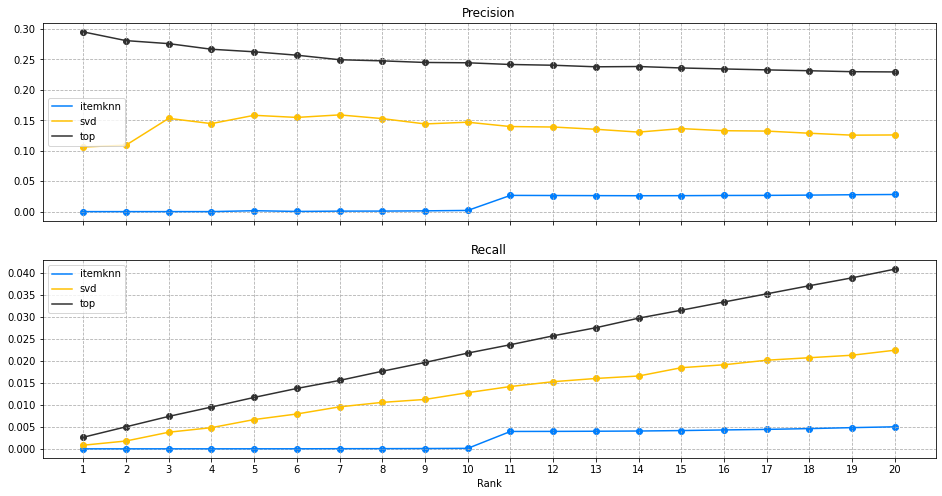

In [34]:
plot_report(classification_report, figsize=(16,8))

## Acurácia de _Feedback_ (_Rating_)

Para analisar a recomendação como um problema de regressão, precisamos:

- Considerar apenas entradas conhecidas ($rating \geq 1$)
- Normalizar o _score_ no mesmo intervalo das avaliações do usuário ($range = [0, 5]$)
- Considerar o tamanho da lista recomendada ($rank$)

In [19]:
def convert_rating_metrics(df, rank=20):
  """known and recommended items"""
  df_true = df
  df_true = df_true.explode('y_true')[['model', 'user_id', 'y_true']]
  df_true['item_id'] = df_true['y_true'].apply(lambda x: x.get('item_id'))
  df_true['y_true'] = df_true['y_true'].apply(lambda x: x.get('rating'))

  df_score = df
  df_score = df_score.explode('y_score')[['model', 'user_id', 'y_score']]
  df_score['item_id'] = df_score['y_score'].apply(lambda x: x.get('item_id'))
  df_score['y_score'] = df_score['y_score'].apply(lambda x: x.get('score'))
  df_score['y_score'] = df_true['y_true'].max() * df_score['y_score'] / df_score['y_score'].max()
  
  df_metrics = df_true.merge(df_score, on=['model', 'user_id', 'item_id'], how='outer')
  df_metrics.sort_values(by=['user_id', 'y_score'], ascending=False, inplace=True)
  df_metrics['rank'] = df_metrics.groupby(['model', 'user_id'])['y_score'].rank(method='first', ascending=False)
  df_metrics = df_metrics.query('y_true > 0 and rank <= @rank')

  return df_metrics[['model', 'user_id', 'item_id', 'y_true', 'y_score']].reset_index(drop=True)

df_metrics = convert_rating_metrics(df.query('model == "itemknn"'), rank=20)
df_metrics

,model,user_id,item_id,y_true,y_score
0,itemknn,6040,1212.0,5.0,4.673407
1,itemknn,5991,2935.0,4.0,5.000000
2,itemknn,5948,2019.0,5.0,5.000000
3,itemknn,5948,1204.0,5.0,5.000000
4,itemknn,5902,1212.0,5.0,4.417727
...,...,...,...,...,...
997,itemknn,10,2662.0,4.0,3.590508
998,itemknn,9,1.0,5.0,3.590508
999,itemknn,8,1.0,4.0,3.590508
1000,itemknn,6,1.0,4.0,3.590508


In [20]:
from rexmex.metrics.rating import root_mean_squared_error, mean_absolute_error

def get_rating_report(df, ranks):
  """Rating report for each rank and model"""
  rating_report = pd.DataFrame(columns=['model', 'rank', 'rmse', 'mae'])
  for rank in ranks:
    for i, model in enumerate(df['model'].unique()):
      df_metrics = convert_rating_metrics(
          df.query('model == @model'),
          rank=rank
      )

      if df_metrics.shape[0] == 0:
        rmse, mae = 0, 0
      else:
        rmse = root_mean_squared_error(df_metrics['y_true'], df_metrics['y_score'])
        mae = mean_absolute_error(df_metrics['y_true'], df_metrics['y_score'])

      rating_report.loc[rating_report.shape[0]] = [model, rank, rmse, mae]
  return rating_report.sort_values(by=['model', 'rank']).reset_index(drop=True)

rating_report = get_rating_report(df, RANKS)
rating_report.tail()

,model,rank,rmse,mae
55,top,16,1.015544,0.824554
56,top,17,1.028665,0.839833
57,top,18,1.050482,0.863155
58,top,19,1.059832,0.874369
59,top,20,1.064216,0.880416


(<Figure size 1152x576 with 2 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f331e6a8b50>,
       dtype=object))

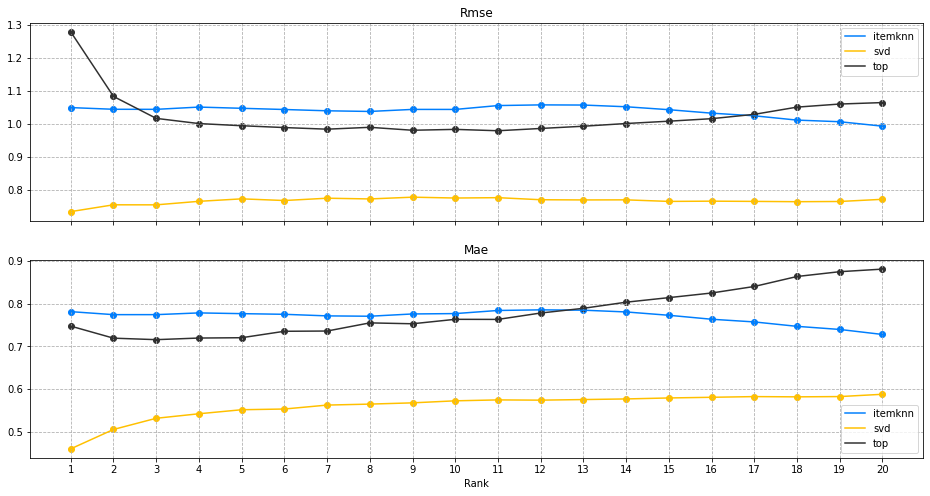

In [21]:
plot_report(rating_report, figsize=(16,8))